# Tasks Minichallenge 1 hpc

## Part 1: Kafka Cluster and Application Setup

### Data Generator functions
The first functions utilizes the Binance Websocket (https://www.binance.com/en/support/faq/binance-options-api-interface-and-websocket-fe0be251ac014a8082e702f83d089e54). It provides data from several different assets with an update speed of 1000ms. The function is written in *notebooks/binance_producer.py* and is started with the docker-compose file *notebooks/docker-compose.yml*. It uses JSON for serializing the data. 

The second functions makes calls to the twitter API and retrieves the most recent tweets regarding cryptocurrencies. The function is written in *notebooks/twitter_producer.py* and also gets started withthe docker-compose file *notebooks/docker-compose.yml*. It uses pickle for serializing the data. 

### Data Processor and Data Sinks
The first data processor for the Binance Websocket Producer retrieves all messages, calculates either a mean, a sum or takes the first and last value recorded. The transformation is made in a Pandas DataFrame and the values get stored in a HDF5 File. 

The second data processor retrieves the messages from the twitter producer and transforms the text of the released tweets. In the first step a text preprocessing is applied and then a sentiment analysis is performed. After this, the calculated values and the text is stored in a HDF5 file. 

### Application components and data flow
![](Application_Overview.png)

#### What are the tasks of the components?
* twitter_producer.py: Making calls to the API every 10 seconds to stay within API limits. Send whole response to Kafka using the pickle serializer. 
* twitter_processor.py: Consuming the messages in the set time interval. Deserializing the data, applying the text transformation and writing the data to the HDF5 File. 
* binance_producer.py: Opening a connection to the binance websocket and maintaining it. Serializing the data using JSON and the utf-8 encoding. Sending the data to Kafka. 
* binance_processor.py: Consuming the messages in the set time interval. Deserializing data, calculating desired values and storing data in HDF5 File. 

#### Which interfaces do the components have?
* twitter_producer.py: The data generator for the twitter data uses the REST API of Twitter and a Kafka Producer. 
* twitter_processor.py: The data processor for the twitter data uses a Kafka Consumer and HDF5 Files. 
* binance_producer.py: The data generator for the binance data uses the Websocket from Binance and a Kafka Producer. 
* binance_processor.py: The data processor for the binance data uses a Kafka Consumer and HDF5 Files. 

#### Why did you devide to use these components?
The only design choice available were the HDF5 files. HDF5 files provide the following advantages:
* well-suited for large amounts of data
* fast write and append operations
* ability to create multiple dataframes within one file
* self-explaining file format

#### Are there any other design decisions you have made?
I choose to use pandas for the calculation of the mean, min and max values for the binance data. Pandas dataframes are easy and fast to construct with JSON data. Transforming them into numpy array would have been more complicated.

#### Which requirements (e.g. libraries, hardware, ...) does a component have?
* twitter_producer.py:
  * kafka
  * pickle
  * requests
* twitter_processor.py
  * kafka
  * h5py
  * nltk
* binance_producer.py
  * websockets
  * kafka
* binance_processor.py
  * pandas
  * h5py
  * kafka

## Part 2: Communication Patterns

### Rewritten Application and containerization
The rewritten application is in the *zmq* folder and can be started with the *zmq/docker-compose.yml* file. It is written using the zeromq framework. 

### Questions
#### Which communication pattern is used by Kafka?
Kafka uses a pub-sub communication pattern. Kafka uses Producers, Consumers and Brokers. Producers produce or publish the messages to a topic, Consumers subscribe to a topic and receive the messages. The broker receives and persists messages directly on the disk. If the messages are consumed by a consumer, they still persist on the disk for consumers. 

#### What is the difference compared to your choosen pattern?
The implementation with zeromq has no service in the middle. It's a push-pull messaging pattern. The generator sends the data directly to the processor or processors. If the data generator service is connected to a port and sends the messages while the receiving service is not running, messages get lost. No messages are persisted within the pattern. Handling bottlenecks or service failures are up to the user. 

#### What are advantages and disadvantages of these patterns?
High performance: ZeroMQ is designed for high-performance messaging, with low latency and high throughput.
Lightweight: ZeroMQ is a lightweight library that is easy to use and integrate into applications.
Flexibility: ZeroMQ provides a wide range of messaging patterns and supports multiple programming languages.
Decentralized: ZeroMQ does not require a centralized message broker, making it a more decentralized messaging system.
Low latency: ZeroMQ's design minimizes latency by avoiding the need for a central broker and using efficient message passing.

##### Push-Pull ZeroMQ
**Advantages:**
* High performance: ZeroMQ is designed for high-performance messaging with low latency and high throughput. 
* Lightweight library
* Flexible message patterns

**Disadvantages:**
* Messages get lost when the data processor is not connected to the data generator. No message persistance. 
* Limited scalability. ZeroMQ's performance can degrade if the number of nodes in a network grows. 
* Has no fault-tolerance. 
* If multiple pull nodes are started, the signals are distributed and no overview of all the incoming messages is available.

##### Pub-Sub Kafka
**Advantages:**
* Kafka is designed for scalability and can handle a large number of consumers. 
* Kafka allows stream processing. The data can be processed and analyzed as it is ingested into the system. 

**Disadvantages:**
* Higher latency
* Complexity

#### How can you scale the two different approaches? What are challenges to be considered?
##### Kafka
Since Kafka is designed to be scaled, there are less challenges compared to ZeroMQ. However, the following challenges can arise:
* Hardware limitations. As the cluster grows more ressources are required. 
* Monitoring. As the cluster grows and is distributed across multiple data centers, monitoring and managing gets more complex. 
* Consumer lag. If consumers can't keep up with the incoming message rate it starts lagging behind and starts impairing the performance of the system.

##### ZeroMQ
* Ressource limitations. As the network grows, more ressources are required.
* Synchronization. ZeroMQ provides asynchronous messaging which can be challenging to synchronize across multiple nodes. The message patterns needs to be designed accordingly. 
* As the system grows it also gets more prone to errors. Since ZeroMQ has no fault-tolerance built in and no messages are persisted a error handling system needs to be implemented. 
* Security. If the data is sent over the internet, encryption and authentication needs to be implemented. 

#### What other 2-3 topologies/patterns do you know used for data processing? Describe the differences and use cases with at least one additional topology.

##### Request/Response
The request and response pattern can be used in distributed systems. Clients send requests to a system, which sends a response back. This pattern is also known as the Client-Server pattern. 

The request and response pattern is very easy to implement and to understand. The pattern is also highly scalable as multiple clients can make requests to the server which can handle them in parallel. This pattern is also very reliable since the client waits for the response before further processing. 

Typical use cases would be web applications and a variety of distributed systems where message delivery is critical. 

##### Exclusive pair
An exclusive pair is consists of one sender and one receiver only. The exclusive pair is very simple to implement since only two nodes are necessary for communication. 

The exclusive pair also guarantees message delivery and is suitable for applications where message delivery is critical. A disadvantage is the scalability. Since the message pattern can only consist of two nodes, the only possibility for scaling is vertical. 

Typical use cases would be applications where it is critical that messages sent are received. Another use case would be when a ressource is allowed to only be accessed from one client. The exclusive pair could be used to lock out the other clients. 

##### Fan-out messaging
Fan-out messaging is a system with one sender and multiple receivers. The messages are sent in a one to many fashion. In this system the sender doesn't know about the receivers and vice versa. The receivers are only responsible for receiving and processing the data. 

Fan-out messaging patterns are scalable. More receivers can be added easily and the sender can send a message in parallel to a large number of receivers. The fan-out messaging pattern is very flexible. Receivers can be added and removed without any changes to the sender. During removal or addition of receivers the sender can also continue to send messages. 

Typical use cases would be broadcasting news to a large number of clients simultaneously. Another typical application would be sending out notifications for events like system failures or maintenance updates. 

#### Which pattern suits your chosen application best?
It's not critical that every message that's sent is also received. The binance processor calculates the values every minute. If a single or even more values are missing, the results are not affected by a lot. 
Same goes for the tweets. The query can't receive all the published tweets. There will always be missing tweets. So when a single tweet is missing, it's not a problem. So the push-pull pattern is suited for both applications. If the throughput would increase and a single receiver is not able to keep up more receivers could be added. 

## Part 3: Performance Analysis and Evaluation

In [151]:
from datetime import datetime
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

In [86]:
def plot_processing_histograms(df:pd.DataFrame):

    if len(df.process_name.unique()) > 1:
        fig, axs = plt.subplots(nrows=len(df.process_name.unique()), figsize=(10,8))
        for i, process in enumerate(list(df.process_name.unique())):
            tmp_plot_df = df[df['process_name'] == process].copy()
            mean, std = tmp_plot_df.duration.mean(), tmp_plot_df.duration.std()

            axs[i].hist(tmp_plot_df.duration, bins=20, label=f"Process times {process}")
            axs[i].set_title(f"Measured process durations for {process}")
            axs[i].set_ylabel("Number of occurences")
            axs[i].set_xlabel("Processing times [s]")
            axs[i].axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
            axs[i].axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
            axs[i].axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
            axs[i].legend()   
            
        plt.tight_layout()
        plt.show()
    else:
        fig, axs = plt.subplots(nrows=len(df.process_name.unique()), figsize=(10,4))
        tmp_plot_df = df.copy()
        process = df.process_name.unique()[0]
        mean, std = tmp_plot_df.duration.mean(), tmp_plot_df.duration.std()

        axs.hist(tmp_plot_df.duration, bins=20, label=f"Process times {process}")
        axs.set_title(f"Measured process durations for {process}")
        axs.set_ylabel("Number of occurences")
        axs.set_xlabel("Processing times [s]")
        axs.axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
        axs.axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
        axs.axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
        axs.legend()   
            
        plt.tight_layout()
        plt.show()

In [186]:
def plot_comparison_to_baseline(baseline_df:pd.DataFrame, df:pd.DataFrame):
    if len(df.process_name.unique()) > 1:
        fig, axs = plt.subplots(nrows=len(df.process_name.unique()), ncols=2, figsize=(8,8))

        for i, process in enumerate(list(df.process_name.unique())):
            tmp_plot_df = df[df['process_name'] == process].copy()
            mean, std = tmp_plot_df.duration.mean(), tmp_plot_df.duration.std()

            axs[i, 0].hist(tmp_plot_df.duration, bins=20, label=f"Process times {process}")
            axs[i, 0].set_title(f"Measured process durations for {process}")
            axs[i, 0].set_ylabel("Number of occurences")
            axs[i, 0].set_xlabel("Processing times [s]")
            axs[i, 0].axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
            axs[i, 0].axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
            axs[i, 0].axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
            axs[i, 0].legend()
            
            tmp_baseline_df = baseline_df[baseline_df['process_name'] == process].copy()
            mean, std = tmp_baseline_df.duration.mean(), tmp_baseline_df.duration.std()
            axs[i, 1].hist(tmp_baseline_df.duration, bins=20, label=f"Process times {process}")
            axs[i, 1].set_title(f"Measured process durations for {process} in Baseline")
            axs[i, 1].set_ylabel("Number of occurences")
            axs[i, 1].set_xlabel("Processing times [s]")
            axs[i, 1].axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
            axs[i, 1].axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
            axs[i, 1].axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
            axs[i, 1].legend()

    else:
        fig, axs = plt.subplots(nrows=len(df.process_name.unique()), ncols=2, figsize=(8,4))
        tmp_plot_df = df.copy()
        tmp_baseline_df = baseline_df.copy()
        process = df.process_name.unique()[0]
        mean, std = tmp_plot_df.duration.mean(), tmp_plot_df.duration.std()
        
        axs[0].hist(tmp_plot_df.duration, bins=20, label=f"Process times {process}")
        axs[0].set_title(f"Measured process durations for {process}")
        axs[0].set_ylabel("Number of occurences")
        axs[0].set_xlabel("Processing times [s]")
        axs[0].axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
        axs[0].axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
        axs[0].axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
        axs[0].legend()   
        
        mean, std = tmp_baseline_df.duration.mean(), tmp_baseline_df.duration.std()
        
        axs[1].hist(tmp_baseline_df.duration, bins=20, label=f"Process times {process}")
        axs[1].set_title(f"Measured process durations for {process} in Baseline")
        axs[1].set_ylabel("Number of occurences")
        axs[1].set_xlabel("Processing times [s]")
        axs[1].axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
        axs[1].axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
        axs[1].axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
        axs[1].legend()   
            
    plt.tight_layout()
    plt.show()

### Baseline Performance

In [68]:
!cd notebooks && docker-compose up --build -d
start = datetime.now()

completed_measurement = False

while completed_measurement == False:
    if (datetime.now() - start).seconds >= 5 * 60:
        completed_measurement = True
    else:
        time.sleep(1)

!cd notebooks && docker-compose down

[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.1s (1/2)                                                         
 => [notebooks-twitter_producer internal] load build definition from Dock  0.0s
 => => transferring dockerfile: 49B                                        0.0s
[+] Building 0.3s (5/5)                                                         
 => [notebooks-twitter_producer internal] load build definition from Dock  0.0s
 => => transferring dockerfile: 49B                                        0.0s
 => [notebooks-twitter_processor

KeyboardInterrupt: 

In [157]:
for filename in os.listdir("notebooks/data"):
    if filename.startswith("pe"):
        df = pd.read_pickle("notebooks/data/" + filename)

### Process times binance processor

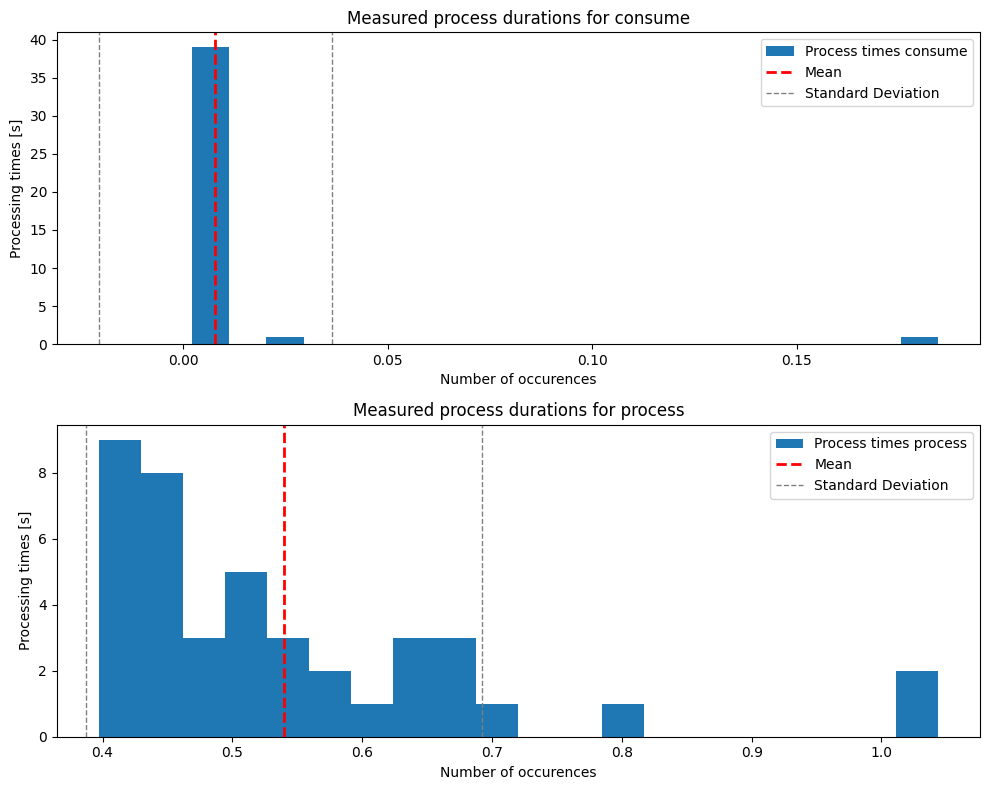

In [160]:
binance_processor_df = pd.DataFrame(df[df.service_name == "binance_processor"])
plot_processing_histograms(binance_processor_df)

### Process times binance producer

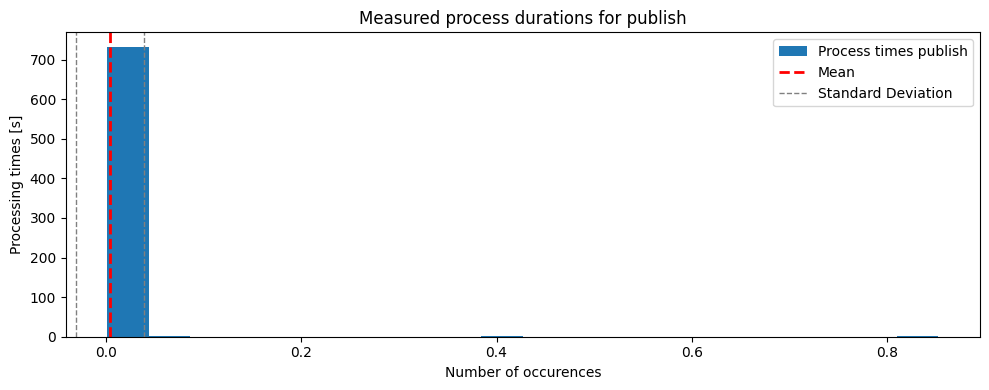

In [161]:
binance_producer_df = pd.DataFrame(df[df.service_name == "binance_producer"])
plot_processing_histograms(binance_producer_df)

### Process times twitter processor

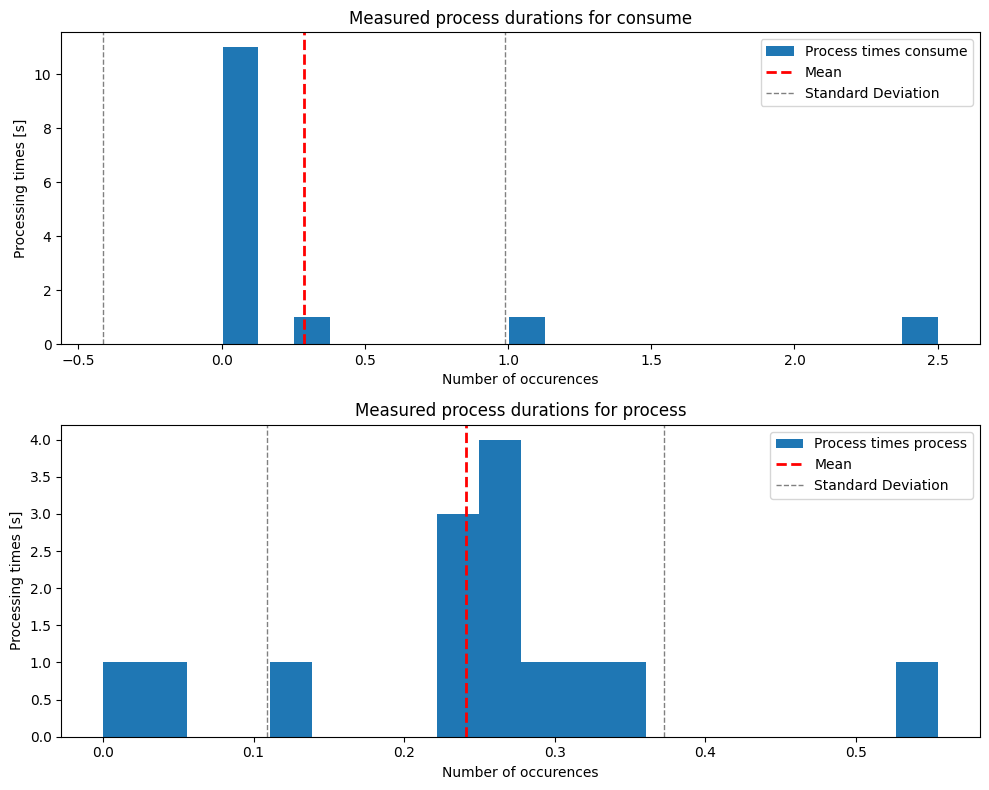

In [162]:
twitter_processor_df = df[df.service_name == "twitter_processor"]
plot_processing_histograms(twitter_processor_df)

### Process times twitter producer

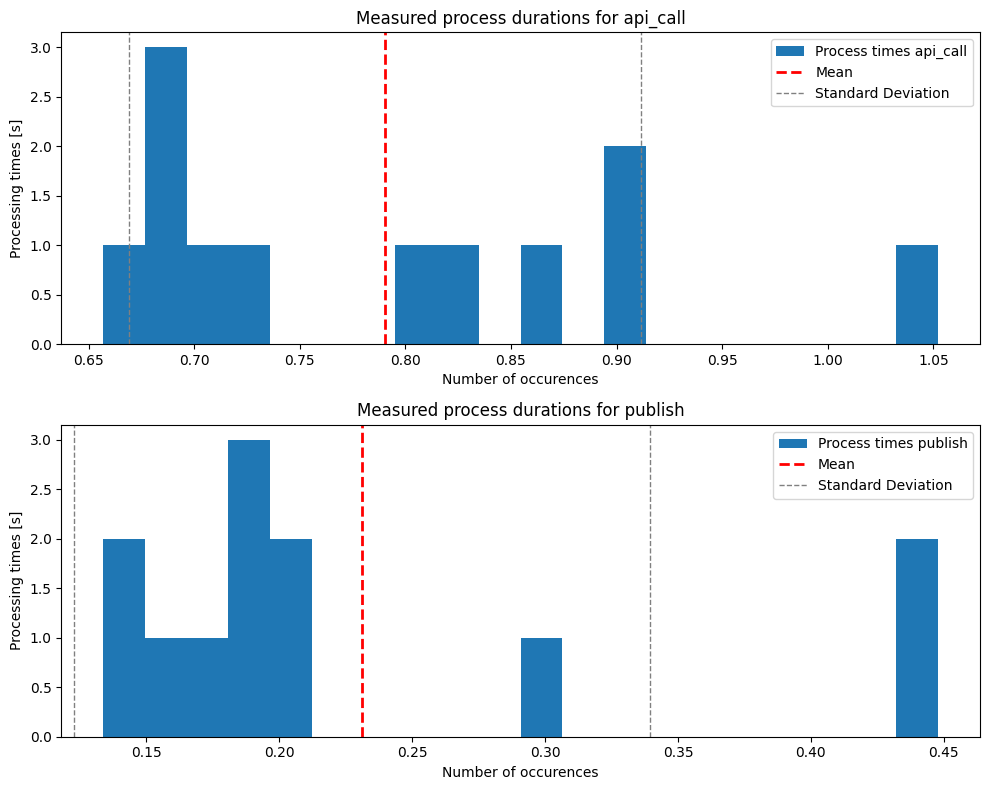

In [163]:
twitter_producer_df = pd.DataFrame(df[df.service_name == "twitter_producer"])
plot_processing_histograms(twitter_producer_df)

### Experiment 1
In the first experiment the producer and consumer services are scaled by a factor of 10. The exception is the Twitter Producer because of the API limitations. The amount of brokers in the Kafka Cluster stays the same. The intent of this experiment is to determine, how the performance of the cluster is affected when the number of producers and consumers is increased. 

In [164]:
!cd notebooks && docker compose -f docker-compose.experiment1.yml up --build -d --scale binance_producer=10 --scale binance_processor=10

start = datetime.now()

completed_measurement = False

while completed_measurement == False:
    if (datetime.now() - start).seconds >= 5 * 60:
        completed_measurement = True
    else:
        time.sleep(1)

!cd notebooks && docker compose down

[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/1)                                                         
[+] Building 0.1s (1/2)                                                         
 => [notebooks-binance_producer internal] load build definition from Dock  0.0s
 => => transferring dockerfil

In [171]:
for filename in os.listdir("notebooks/data_experiment1"):
    if filename.startswith("pe"):
        df = pd.read_pickle("notebooks/data_experiment1/" + filename)

for filename in os.listdir("notebooks/data"):
    if filename.startswith("pe"):
        baseline_df = pd.read_pickle("notebooks/data/" + filename)

### Process times binance processor

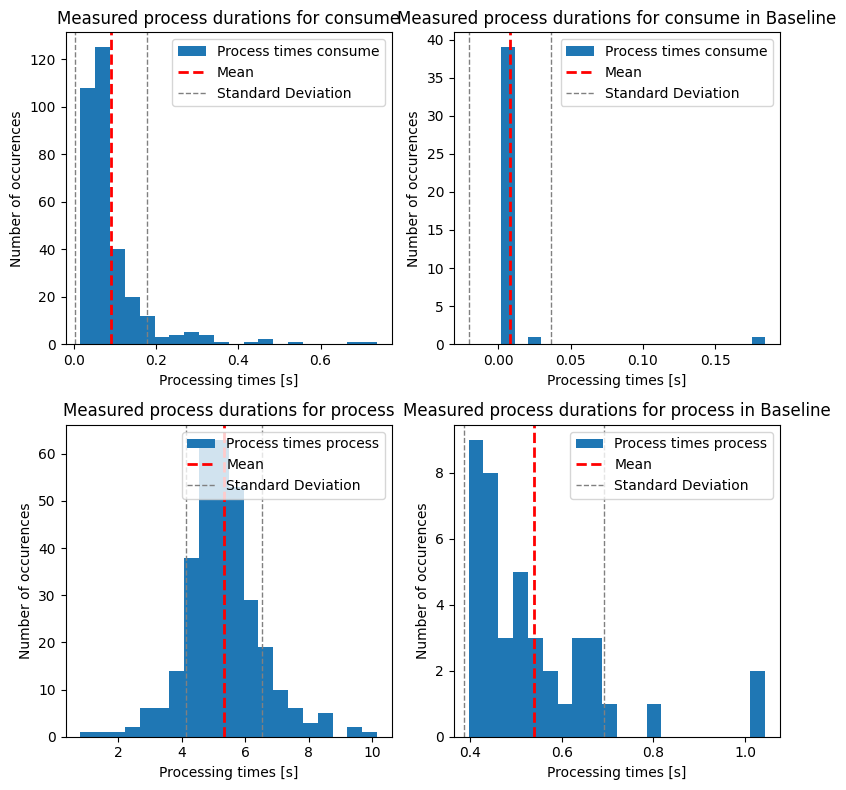

In [184]:
binance_processor_df = df[df.service_name == "binance_processor"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "binance_processor"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

### Process times binance producer

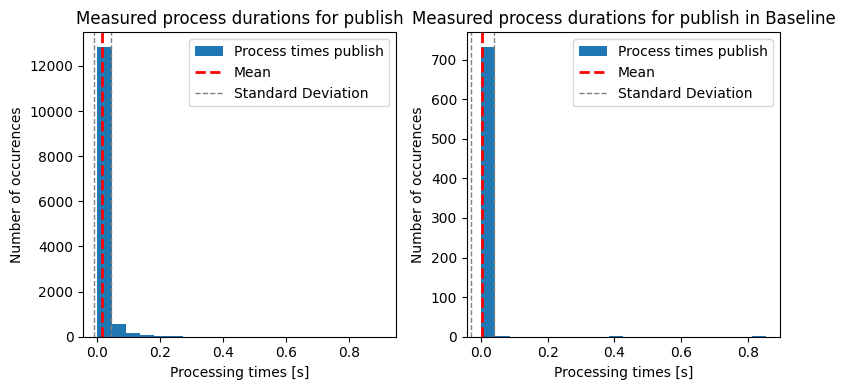

In [188]:
binance_processor_df = df[df.service_name == "binance_producer"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "binance_producer"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

### Process times twitter processor

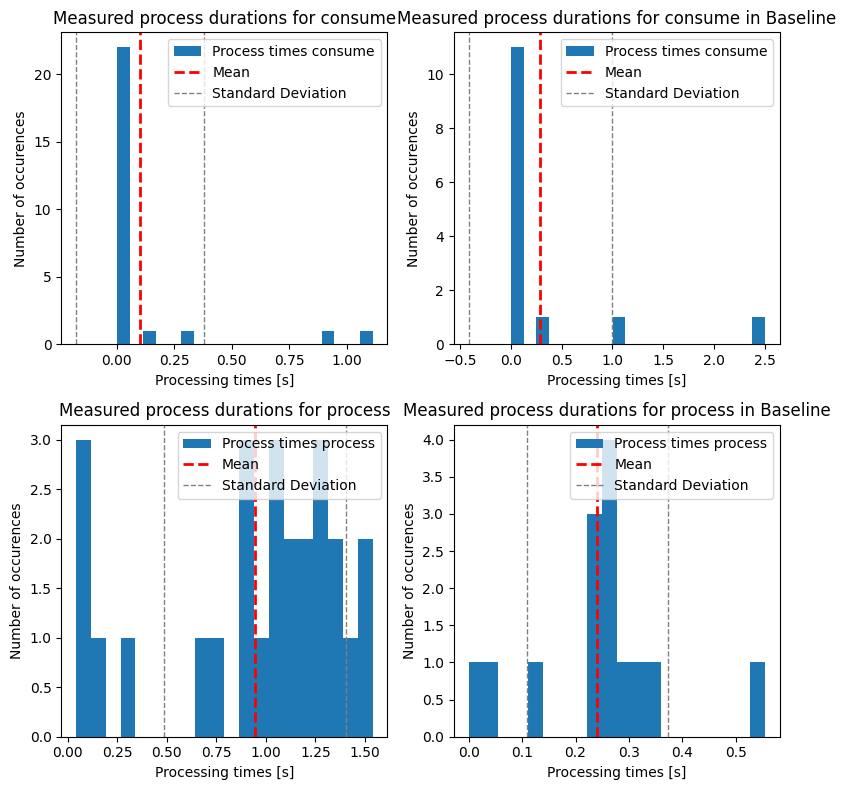

In [191]:
binance_processor_df = df[df.service_name == "twitter_processor"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "twitter_processor"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

### Process times twitter producer

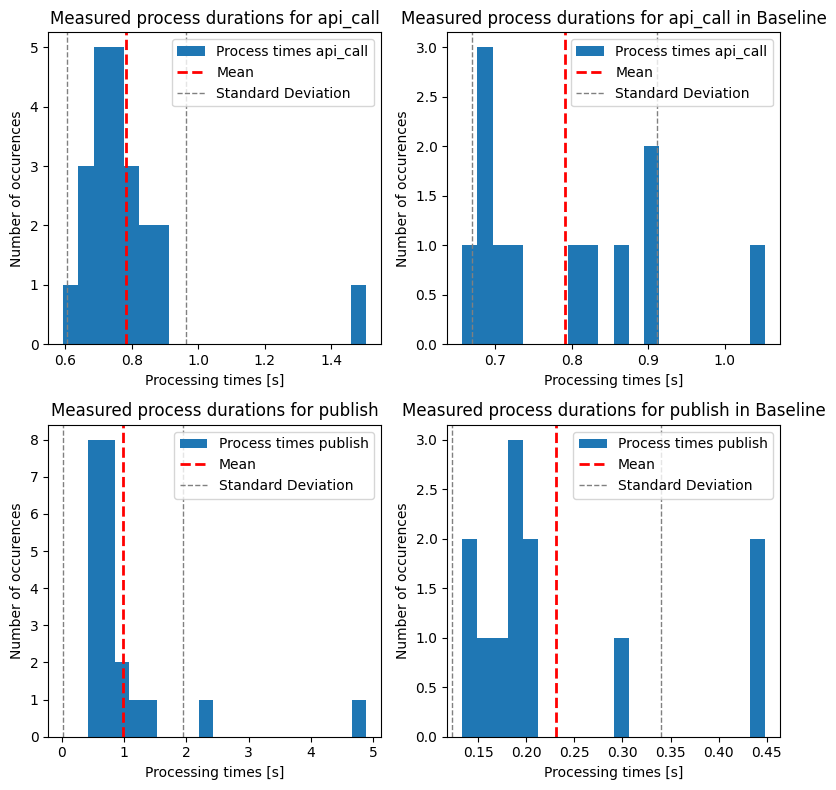

In [192]:
binance_processor_df = df[df.service_name == "twitter_producer"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "twitter_producer"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

### Experiment 2
In the second experiment the producer and consumer services are again scaled by 10, but the number of brokers is doubled. The intent of this experiment is to determine, how the performance of the cluster is affected, when the amount of brokers within the cluster is increased. 

In [147]:
!cd notebooks && docker compose -f docker-compose.experiment2.yml up --build -d --scale binance_producer=10 --scale binance_processor=10

start = datetime.now()

completed_measurement = False

while completed_measurement == False:
    if (datetime.now() - start).seconds >= 5 * 60:
        completed_measurement = True
    else:
        time.sleep(1)

!cd notebooks && docker compose down

[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/1)                                                         
[+] Building 0.1s (1/2)                                                         
 => [notebooks-binance_producer internal] load build definition from Dock  0.0s
 => => transferring dockerfile: 49B                                        0.0s
[+] Building 0.3s (5/5)                                                         
 => [notebooks-binance_producer internal] load build definition from Dock  0.0s
 => => transferring dockerfile:

### Process times binance processor

In [148]:
with open("notebooks/data_experiment2/binance/performance_binance_processor.pkl", "rb") as f:
    binance_processor_data = pickle.load(f)

binance_processor_df = pd.DataFrame(binance_processor_data)
binance_processor_data
plot_processing_histograms(binance_processor_df)

UnpicklingError: invalid load key, '\x01'.

### Process times binance producer

In [ ]:
with open("notebooks/data_experiment2/binance/performance_binance_producer.pkl", "rb") as f:
    binance_producer_data = pickle.load(f)

binance_producer_df = pd.DataFrame(binance_producer_data)
plot_processing_histograms(binance_producer_df)

UnpicklingError: invalid load key, '\x01'.

### Process times twitter processor

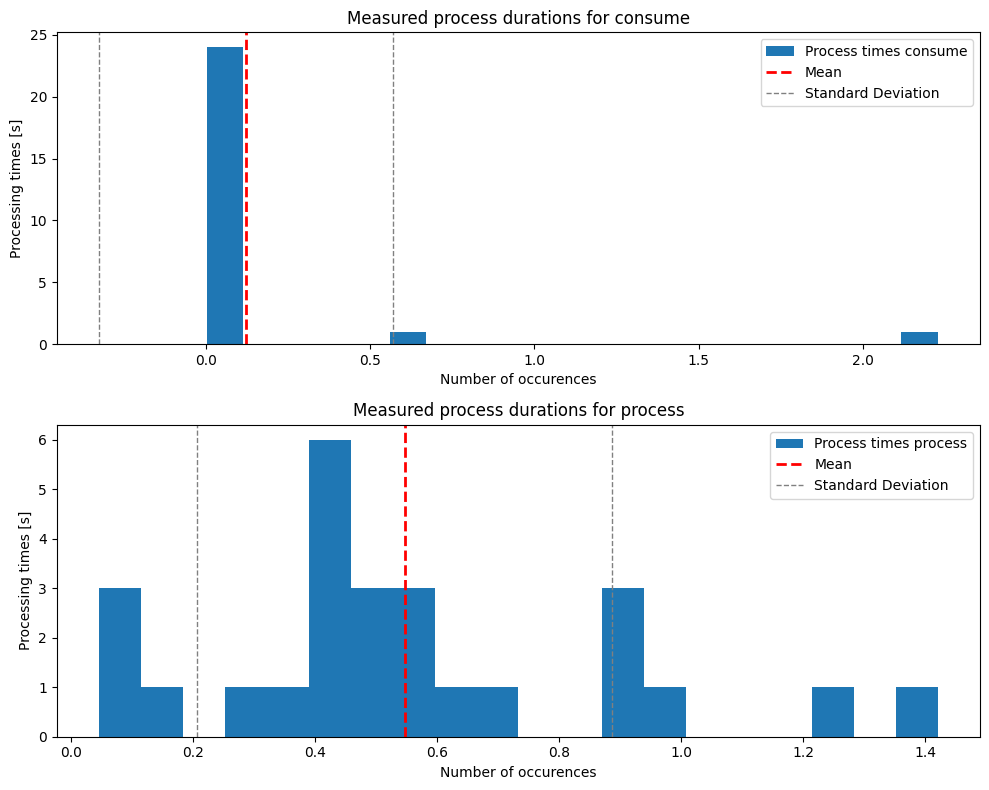

In [ ]:
with open("notebooks/data_experiment2/twitter/performance_twitter_processor.pkl", "rb") as f:
    twitter_processor_data = pickle.load(f)

twitter_processor_df = pd.DataFrame(twitter_processor_data)
plot_processing_histograms(twitter_processor_df)

### Process times twitter producer

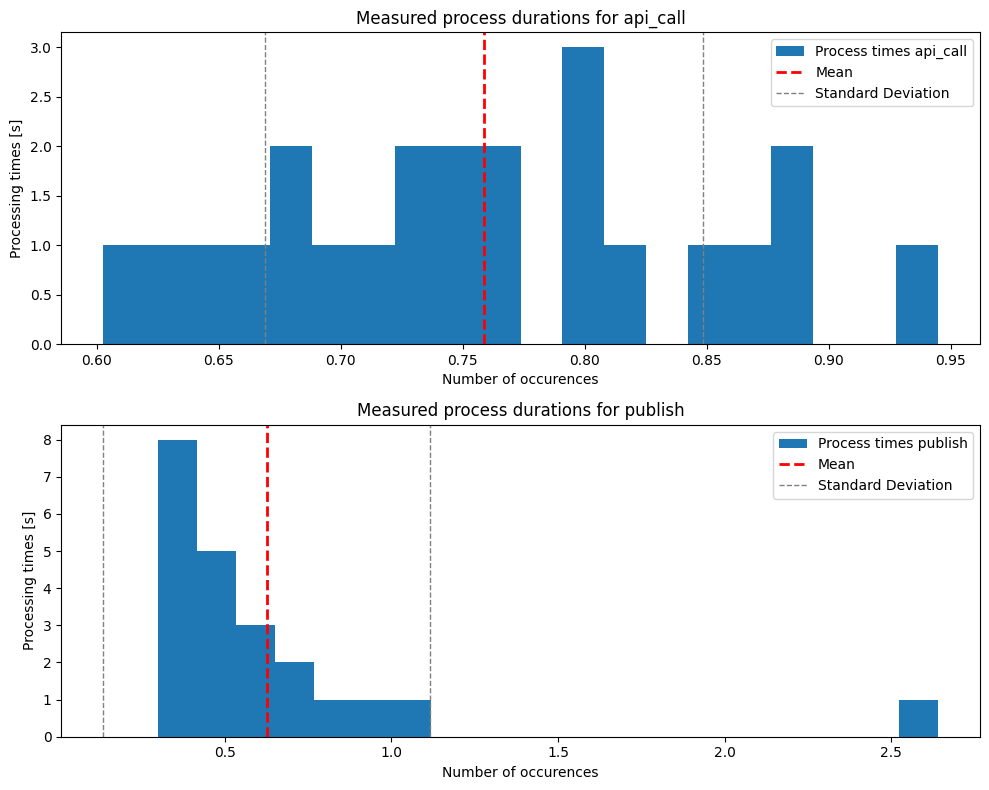

In [ ]:
with open("notebooks/data_experiment2/twitter/performance_twitter_producer.pkl", "rb") as f:
    twitter_producer_data = pickle.load(f)

twitter_producer_df = pd.DataFrame(twitter_producer_data)
plot_processing_histograms(twitter_producer_df)

### Experiment 3
In the third experiment the producer and consumer services are scaled by a factor of 10, the number of brokers is the same as in experiment 2, six. What changes is the replication factor for the topics. The intent of the experiment is to show how the replication factor affects the performance of the cluster. 

In [ ]:
!cd notebooks && docker compose -f docker-compose.experiment3.yml up --build -d --scale binance_producer=10 --scale binance_processor=10

start = datetime.now()

completed_measurement = False

while completed_measurement == False:
    if (datetime.now() - start).seconds >= 5 * 60:
        completed_measurement = True
    else:
        time.sleep(1)

!cd notebooks && docker compose down